# 项目：指导四轴飞行器学会飞行

设计一个能够使四轴飞行器飞行的智能体，然后使用你选择的强化学习算法训练它！

请尝试运用你在这一单元中学到的知识，看看哪个方法效果最好，当然你也可以自己想出创新型方法并测试它们。
## 说明

请查看目录下的文件，以更好地了解项目结构。 

- `task.py`：在本文件中定义你的任务（环境）。
- `agents/`：本文件夹中包含强化学习智能体。
    - `policy_search.py`：我们为你提供了一个智能体模板。
    - `agent.py`：在本文件中开发你的智能体。
- `physics_sim.py`：本文件中包含四轴飞行器模拟器。**请勿修改本文件**。

在本项目中，你需要在 `task.py` 中定义你的任务。尽管我们为你提供了一个任务示例，来帮助你开始项目，但你也可以随意更改这个文件。在这个 notebook 中，你还将学习更多有关修改这个文件的知识。

你还需要在 `agent.py` 中设计一个强化学习智能体，来完成你选择的任务。

我们也鼓励你创建其他文件，来帮助你整理代码。比如，你也许可以通过定义一个 `model.py` 文件来定义其他你需要的神经网络结构。

## 控制四轴飞行器

在下方的代码中，我们提供了一个智能体示例，来示范如何使用模拟器来控制四轴飞行器。这个智能体比你在 notebook 中需要测试的智能体（在 `agents/policy_search.py` 中）更加简单！

这个智能体通过设置飞行器四个轴上的转速来控制飞行器。`Basic_Agent` 类中提供的智能体将会随机为四个轴指定动作。这四个速度将通过 `act` 方法以四个浮点数列表的形式返回。

在本项目中，你将在 `agents/agent.py` 中实现的智能体会以更加智能的方法进行指定的动作。

In [23]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/dl_p5_quadcopter


In [3]:
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/dl_p5_quadcopter')
!pwd

/content/gdrive/My Drive/Colab Notebooks/dl_p5_quadcopter


In [4]:
!ls

agents	     Quadcopter_Project.ipynb	       README.md
data.txt     Quadcopter_Project_zh.ipynb       resource
__pycache__  Quadcopter_Project_zh_test.ipynb  tasks


In [25]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as p
import csv
import numpy as np
import random

# Agents
from agents.policy_search import PolicySearch_Agent
from agents.agent import DDGP

# Tasks
from tasks.basic_task import Task
from tasks.ddgp_task import Task as ddgp_task

# Plot
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### plot

In [0]:
def plot_run(results, standalone=True):
    if standalone:
        plt.subplots(figsize=(15, 15))
    
    #查看四轴飞行器的位置变化
    plt.subplot(3, 3, 1)
    plt.title('Position')
    plt.plot(results['time'], results['x'], label='x')
    plt.plot(results['time'], results['y'], label='y')
    plt.plot(results['time'], results['z'], label='z')
    plt.xlabel('time, seconds')
    plt.ylabel('Position')
    plt.grid(True)
    if standalone:
        plt.legend()

    #四轴飞行器的速度
    plt.subplot(3, 3, 2)
    plt.title('Velocity')
    plt.plot(results['time'], results['x_velocity'], label='x_hat')
    plt.plot(results['time'], results['y_velocity'], label='y_hat')
    plt.plot(results['time'], results['z_velocity'], label='z_hat')
    plt.xlabel('time, seconds')
    plt.ylabel('Velocity')
    plt.grid(True)
    if standalone:
        plt.legend()
    
    #绘制欧拉角 (Euler angles)（四轴飞行器围绕 x，y 和 z 轴的旋转）的图表
    plt.subplot(3, 3, 3)
    plt.title('Orientation')
    plt.plot(results['time'], results['phi'], label='phi')
    plt.plot(results['time'], results['theta'], label='theta')
    plt.plot(results['time'], results['psi'], label='psi')
    plt.xlabel('time, seconds')
    plt.grid(True)
    if standalone:
        plt.legend()
    
    #绘制每个欧拉角的速度（每秒的弧度）图
    plt.subplot(3, 3, 4)
    plt.title('Angular Velocity')
    plt.plot(results['time'], results['phi_velocity'], label='phi')
    plt.plot(results['time'], results['theta_velocity'], label='theta')
    plt.plot(results['time'], results['psi_velocity'], label='psi')
    plt.xlabel('time, seconds')
    plt.grid(True)
    if standalone:
        plt.legend()

    #最后，你可以使用下方代码来输出智能体选择的动作。
    plt.subplot(3, 3, 5)
    plt.title('Rotor Speed')
    plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1')
    plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2')
    plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3')
    plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4')
    plt.xlabel('time, seconds')
    plt.ylabel('Rotor Speed, revolutions / second')
    plt.grid(True)
    if standalone:
        plt.legend()

    if standalone:
        plt.tight_layout()
        plt.show()

In [0]:
from mpl_toolkits.mplot3d.axes3d import Axes3D


def plot_point3d(ax, x, y, z, **kwargs):
    ax.scatter([x], [y], [z], **kwargs)
    ax.text(x, y, z, "({:.1f}, {:.1f}, {:.1f})".format(x, y, z))


def show_flight_path(results, target=None):
    results = np.array(results)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    ax.plot3D(results[:, 0], results[:, 1], results[:, 2], 'gray')
    
    if target is not None:
        plot_point3d(ax, *target[0:3], c='y', marker='x', s=100, label='target')
        
    plot_point3d(ax, *results[0, 0:3], c='g', marker='o', s=50, label='start')
    plot_point3d(ax, *results[-1, 0:3], c='r', marker='o', s=50, label='end')
    
    ax.legend()

### random Agent

In [0]:
class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

运行下方代码，让智能体指定动作来控制四轴飞行器。

请随意更改我们提供的 `runtime`，`init_pose`，`init_velocities` 和 `init_angle_velocities` 值来更改四轴飞行器的初始条件。

下方的 `labels` 列表为模拟数据的注释。所有的信息都储存在 `data.txt` 文档中，并保存在 `results` 目录下。

In [0]:
# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

In [0]:
# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 
          'phi', 'theta', 'psi', 
          'x_velocity', 'y_velocity', 'z_velocity', 
          'phi_velocity', 'theta_velocity', 'psi_velocity', 
          'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

In [0]:
# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

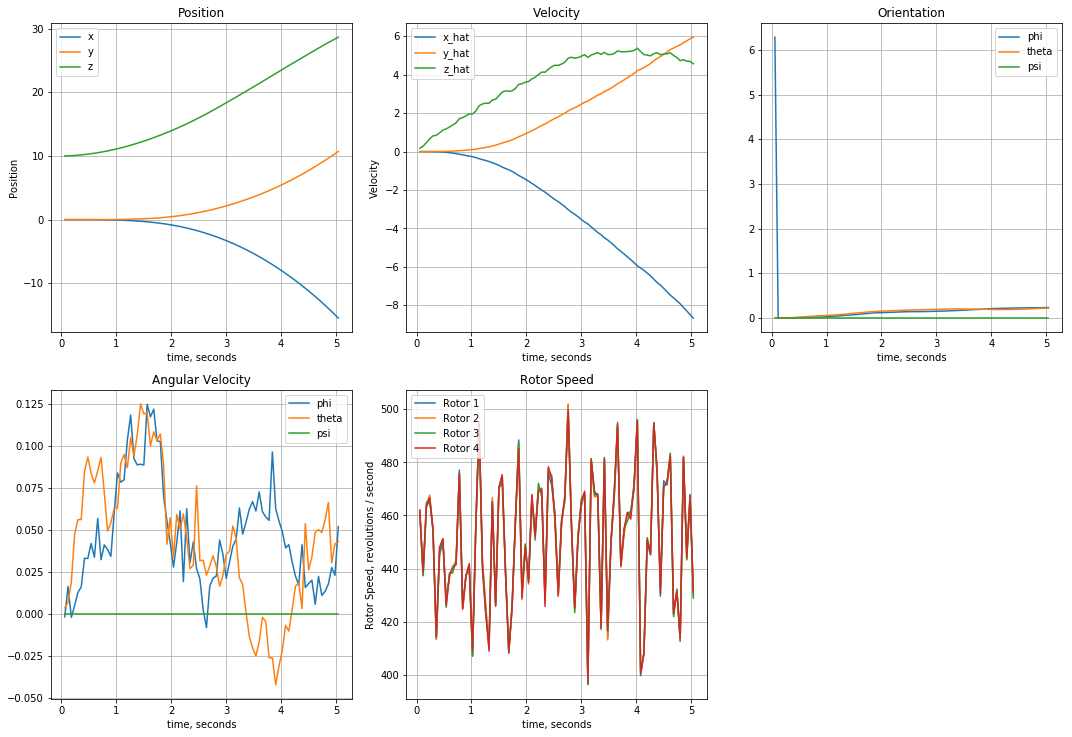

In [32]:
plot_run(results)

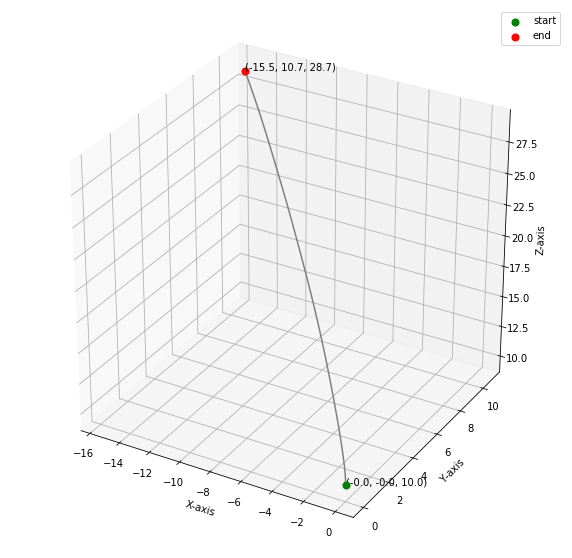

In [33]:
path = [[results['x'][i], results['y'][i], results['z'][i]] for i in range(len(results['x']))]
show_flight_path(path, target=None)

在指定任务之前，你需要在模拟器中衍生环境状态。运行下方代码来在模拟结束时输出以下变量值：

- `task.sim.pose`：四周飞行器在 ($x,y,z$) 坐标系中的位置和欧拉角。
- `task.sim.v`：四轴飞行器在 ($x,y,z$) 坐标系中的速度。
- `task.sim.angular_v`：三个欧拉角的弧度/每秒。

In [34]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-15.46239563  10.70418128  28.66536636   0.2355508    0.22120306
   0.        ]
[-8.66156823  5.95576233  4.57235753]
[0.0517874  0.04284429 0.        ]


在 `task.py` 中的任务示例中，我们使用了四轴飞行器六个维度的动作来构建每个时间步的环境状态。然而，你也可以按照自己的意愿更改任务，你可以添加速度信息来扩大状态向量，也可以使用任何动作、速度和角速度的组合，并构造适用于你的任务的环境状态。

## 任务

在 `task.py` 中，我们为你提供了一个任务示例。请在新窗口中打开这个文件。

使用 `__init__()` 方法来初始化指定本任务所需的几个变量。

- 模拟器作为 `PhysicsSim` 类（来自 `physics_sim.py` 文件）的示例进行初始化。
- 受到 DDPG 论文中研究方法的启发，我们使用了重复调用动作的方法。对于智能体的每一个时间步，我们将利用 `action_repeats` 时间步来进行模拟。如果你并不熟悉这种方法，可以阅读 [DDPG 论文](https://arxiv.org/abs/1509.02971)的结论部分。
- 我们设置了状态向量中每个分量的数值。在任务示例中，我们只设置了六个维度的动作信息。为了设定向量大小（`state_size`），我们必须考虑重复的动作。
- 任务环境通常是一个四维动作空间，每个轴有一个输入（`action_size=4`）。你可以设置每个输入的最小值（`action_low`）和最大值（`action_high`）。
- 我们在文件中提供的任务示例将使智能体达到目标位置。我们将目标位置设置为一个变量。

`reset()` 方法将重置模拟器。每当阶段结束时，智能体都将调用此方法。你可以查看下方代码中的例子。

`step()` 方法是最重要的一个方法。它将接收智能体选择的动作 `rotor_speeds`，并准备好下一个状态，同时返回给智能体。接着，你将通过 `get_reward()` 计算奖励值。当超过规定时间，或是四轴飞行器到达模拟器边缘时，这一阶段将视作结束。

接下来，你将学习如何测试这个任务中智能体的性能。

## 智能体

`agents/policy_search.py` 文件中提供的智能体示例使用了非常简单的线性策略，将动作向量视作状态向量和矩阵权重的点积直接进行计算。接着，它通过添加一些高斯噪声来随机干扰参数，以产生不同的策略。根据每个阶段获得的平均奖励值（`score`），它将记录迄今为止发现的最佳参数集以及分数的变化状态，并据此调整比例因子来扩大或减少噪音。

请运行下方代码来查看任务示例中智能体的性能。

In [0]:
# Setup
labels = ['time', 'x', 'y', 'z', 
          'phi', 'theta', 'psi', 
          'x_velocity', 'y_velocity', 'z_velocity', 
          'phi_velocity', 'theta_velocity', 'psi_velocity', 
          'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

In [0]:
num_episodes = 1
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 


In [37]:
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        if i_episode == num_episodes:
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =    1, score =   2.951 (best =   2.951), noise_scale = 0.05

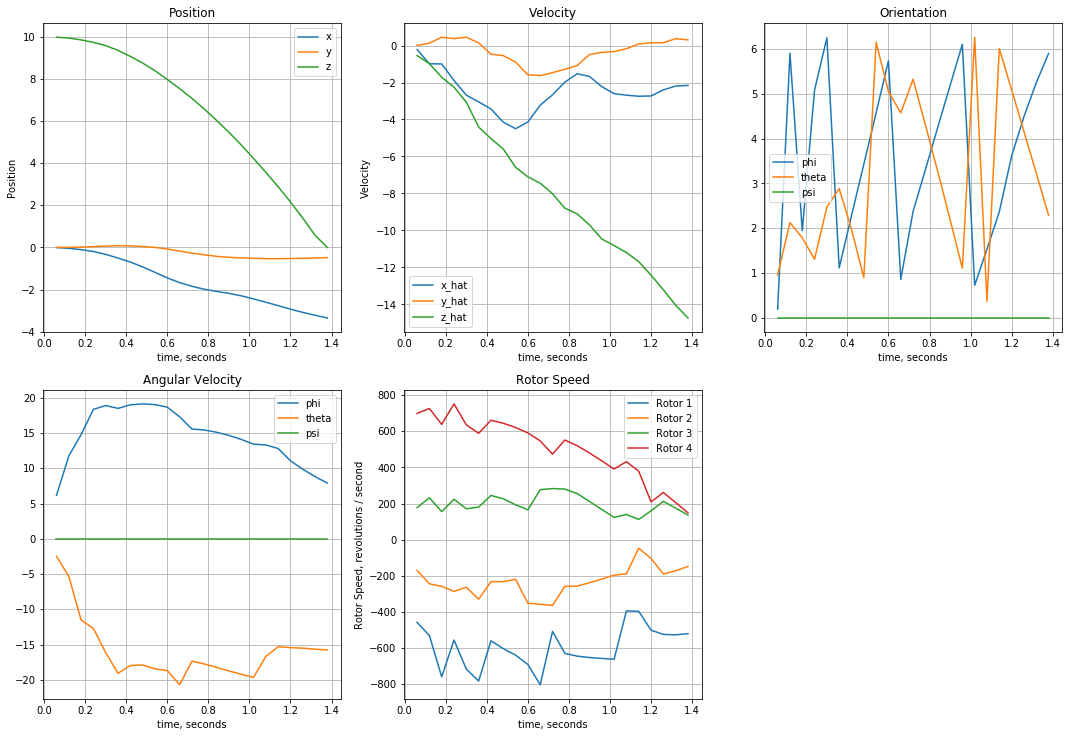

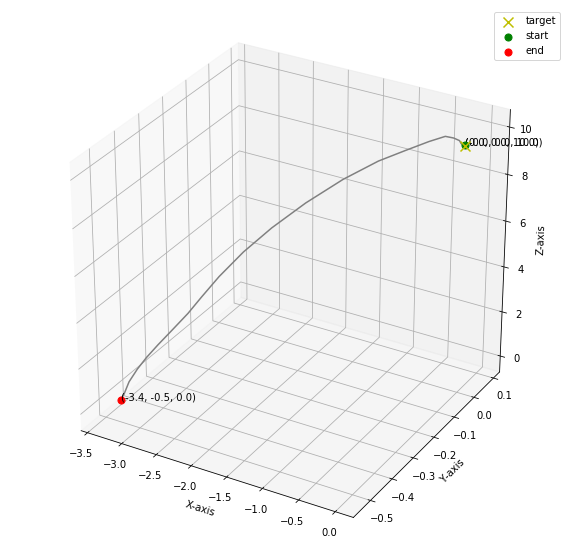

In [38]:
plot_run(results)

path = [[results['x'][i], results['y'][i], results['z'][i]] for i in range(len(results['x']))]
show_flight_path(path, target=target_pos)

这个智能体的性能想必十分糟糕！现在轮到你出场了！

## 定义任务，设计并训练你的智能体！

修改 `task.py` 文件来指定你所选择的任务。如果你不确定选择什么任务，你可以教你的四轴飞行器起飞、盘旋、着陆或是达到指定位置。


在指定任务后，使用 `agents/policy_search.py` 中的智能体示例作为模板，来在 `agents/agent.py` 中定义你自己的智能体。你可以随意从智能体示例中借用你需要的元素，包括如何模块化你的代码（使用 `act()`，`learn()` 和 `reset_episode_vars()` 等辅助方法）。

请注意，你指定的第一个智能体和任务**极有可能**无法顺利进行学习。你将需要改进不同的超参数和奖励函数，直到你能够获得不错的结果。

在开发智能体的时候，你还需要关注它的性能。参考下方代码，建立一个机制来存储每个阶段的总奖励值。如果阶段奖励值在逐渐上升，说明你的智能体正在学习。

In [0]:
## TODO: Train your agent here.

# Parameters of task
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([3., 2., 6.])              # target pose

# Setup task
task = ddgp_task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)

In [0]:
# Setup agent
agent = DDGP(task)

In [0]:
# Parameters
rewards = []
best_score = -1e6
worst_score = 1e6

In [0]:
# A dictionary to store the flying states
labels = ['time', 'x', 'y', 'z', 
          'phi', 'theta', 'psi', 
          'x_velocity', 'y_velocity', 'z_velocity', 
          'phi_velocity', 'theta_velocity', 'psi_velocity', 
          'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

In [57]:
num_episodes = 500

# Episode
for i_episode in range(1, num_episodes+1): 
    state = agent.reset_episode() # start a new episode
    score = 0
    
    # Runtime
    while True: # while True means loop forever
        action = agent.act(state)  # Returns a list of actions for given state(s) as per current policy
        next_state, reward, done = task.step(action)    
        
        if i_episode == num_episodes:
            to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
        
        agent.step(action, reward, next_state, done)
        state = next_state
        
        score += reward
        best_score = max(best_score, score)
        worst_score = min(worst_score, score)
        
        
        text = "\rEpisode = {:1d}, Score = {:1.3f}  ||  Best: {:1.3f}, Worst: {:1.3f}  ||  Position: x:{:1.2f}, y:{:1.2f}, z:{:1.2f}".format(
            i_episode, score, best_score, worst_score, task.sim.pose[0], task.sim.pose[1], task.sim.pose[2])

        if done: # done = True when runtime is over, or it is outside the bounds
            if i_episode % 10 == 0:
              print(text)
            print(text, end="")
            break

    rewards.append(score)  
    
    sys.stdout.flush()

Episode = 10, Score = 78.000  ||  Best: 96.000, Worst: 3.000  ||  Position: x:-0.25, y:0.77, z:0.00
Episode = 20, Score = 90.000  ||  Best: 96.000, Worst: 3.000  ||  Position: x:-3.03, y:5.47, z:0.00
Episode = 30, Score = 78.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-0.73, y:-0.04, z:0.00
Episode = 40, Score = 72.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-2.38, y:0.98, z:0.00
Episode = 50, Score = 78.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-0.34, y:-0.51, z:0.00
Episode = 60, Score = 81.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-0.03, y:-0.13, z:0.00
Episode = 70, Score = 75.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-1.05, y:-1.73, z:0.00
Episode = 80, Score = 78.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-1.45, y:-0.45, z:0.00
Episode = 90, Score = 72.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-1.58, y:1.83, z:0.00
Episode = 100, Score = 69.000  ||  Best: 102.000, Worst: 3.000  ||  Position: x:-1.23, y

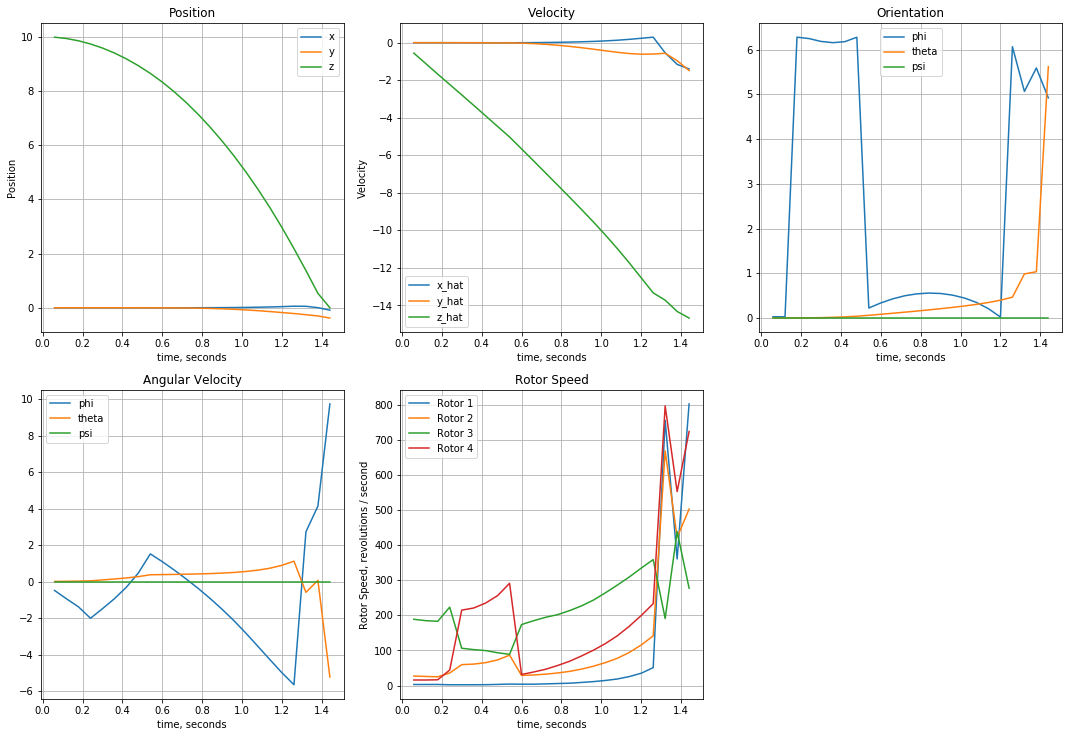

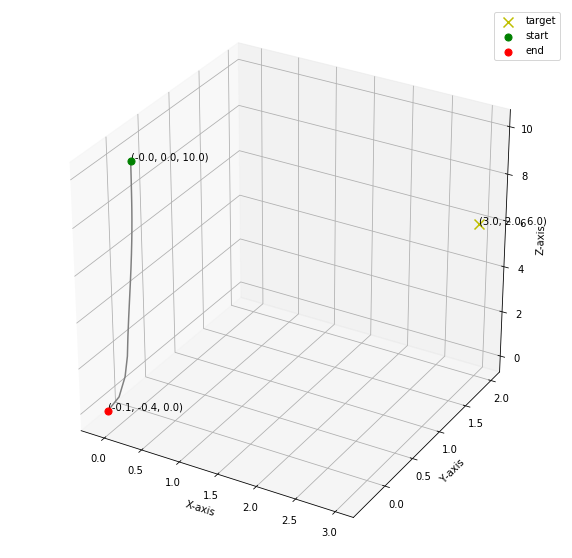

In [58]:
plot_run(results)

path = [[results['x'][i], results['y'][i], results['z'][i]] for i in range(len(results['x']))]
show_flight_path(path, target=target_pos)

## 绘制阶段奖励

请绘制智能体在每个阶段中获得的总奖励，这可以是单次运行的奖励值，也可以是多次运行的平均值。

注：一个阶段（episode）里面包括有许多次的“runtime”
- 一次for 循环是一个阶段Episode
- 一次while循环是一次runtime

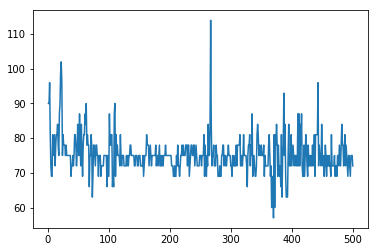

In [59]:
## TODO: Plot the rewards.
episodes = range(1, num_episodes+1)

plt.plot(episodes, rewards)
plt.show()


## 回顾

**问题 1**：请描述你在 `task.py` 中指定的任务。你如何设计奖励函数？

**回答**：


**问题 2**：请简要描述你的智能体，你可以参考以下问题：


你尝试了哪些学习算法？哪个效果最好？

 - 使用了DDGP算法。

你最终选择了哪些超参数（比如 $\alpha$，$\gamma$，$\epsilon$ 等）？

 - bitch size = 64
 - Tau (soft target update rate) = 0.001
 - Learning rate for the actor = 0.0001
 - Learning rate for the critic = 0.001
 - Gamma = 0.99
 - buffer_size = 1000000
 - mu = 0
 - theta = 0.15
 - sigma = 0.2

你使用了什么样的神经网络结构（如果有的话）？请说明层数、大小和激活函数等信息。

- 行动者:

 - Dense(units=512) + L2 Regularisation + BatchNorm  + ReLu Activation
 - Dense(units=216) + L2 Regularisation + BatchNorm  + ReLu Activation
 - Dense + Sigmoid Activation

- 评论者: 状态层、行动层同上；合并后使用 ReLu Activation


**问题 3**：根据你绘制的奖励图，描述智能体的学习状况。

- 学习该任务是简单还是困难？
- 该学习曲线中是否存在循序渐进或急速上升的部分？
- 该智能体的最终性能有多好？（比如最后十个阶段的平均奖励值）

**回答**：



**问题 4**：请简要总结你的本次项目经历。你可以参考以下问题：

- 本次项目中最困难的部分是什么？（例如开始项目、运行 ROS、绘制、特定的任务等。）
- 关于四轴飞行器和你的智能体的行为，你是否有一些有趣的发现？

**回答**：



### (可选)Plot Actor 及 Critic 结构
建议使用 ```from keras.utils import plot_model``` 来显示模型结构；